In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
import os
import time
import random as rd
import torch
from scipy.special import comb, perm
  

In [ ]:
def soft_comp(x, threshold):
    mask1 = x > threshold
    mask2 = x < -threshold
    out = torch.zeros_like(x)
    out += mask1.float() * -threshold + mask1.float() * x
    out += mask2.float() * threshold + mask2.float() * x
    return out


class LISTA(nn.Module):
    def __init__(self, _w1_, _w2_, C, stage, alpha, thr, useGPU):
        super(LISTA, self).__init__()
        self.alpha = alpha
        self.stage = stage
        self._flat_weights_names = []
        self._all_weights = []
        self.n = _w2_.shape[0]
        self.ret = dict()
        for layer in range(self.stage):
          self.ret[layer]=dict()
          self.ret[layer]['real'] = []
          self.ret[layer]['imag'] = []

        if (useGPU):
            self.C_real = (nn.Parameter(torch.from_numpy(C.real))).cuda()
            self.C_imag = (nn.Parameter(torch.from_numpy(C.imag))).cuda()
        else:
            self.C_real = nn.Parameter(torch.from_numpy(C.real))
            self.C_imag = nn.Parameter(torch.from_numpy(C.imag))

        for layer in range(stage):

            conv1d_1 = nn.Conv1d(1, 2, 4, padding=1)   #
            # # 加上一层relu
            conv1d_2 = nn.Conv1d(2, 1, 2, padding=1)   # output channel is one

            conv1d_3 = nn.Conv1d(1, 2, 4, padding=1)

            conv1d_4 = nn.Conv1d(2, 1, 2, padding=1)

            conv1d_1 = conv1d_1.double()
            conv1d_2 = conv1d_2.double()

            conv1d_3 = conv1d_3.double()
            conv1d_4 = conv1d_4.double()

            w_real = nn.Parameter(torch.from_numpy(_w2_.real))
            w_imag = nn.Parameter(torch.from_numpy(_w2_.imag))
            b_real = nn.Parameter(torch.from_numpy(_w1_.real))
            b_imag = nn.Parameter(torch.from_numpy(_w1_.imag))

            th = nn.Parameter(torch.tensor(thr))

            if (useGPU):
                conv1d_1 = conv1d_1.cuda()
                conv1d_2 = conv1d_2.cuda()
                conv1d_3 = conv1d_3.cuda()
                conv1d_4 = conv1d_4.cuda()
                w_real = w_real.cuda()
                w_imag = w_imag.cuda()
                b_real = b_real.cuda()
                b_imag = b_imag.cuda()
                th = th.cuda()

            layer_params = (w_real, w_imag, b_real, b_imag, th, conv1d_1, conv1d_2, conv1d_3, conv1d_4)
            suffix = ''
            param_names = ['weights_real_{}{}', 'weights_imag_{}{}',
                           'bias_real_{}{}', 'bias_imag_{}{}', 'threshold{}{}', 'conv1d_1_{}{}', 'conv1d_2_{}{}', 'conv1d_3_{}{}', 'conv1d_4_{}{}']
            param_names = [x.format(layer, suffix) for x in param_names]
            for name, param in zip(param_names, layer_params):
                setattr(self, name, param)
            self._flat_weights_names.extend(param_names)
            self._all_weights.append(param_names)


    def forward(self, y_real, y_imag):
        self.bs = y_real.shape[-1]
        '''
                # param_names = ['weights_real_{}{}', 'weights_imag_{}{}',
                #                'bias_real_{}{}', 'bias_imag_{}{}', 'threshold{}{}']
                # w2_real, w2_imag, w1_real, w1_imag, threshold
        '''

        x_real = torch.zeros([self.n, self.bs],dtype=torch.float64)
        x_imag = torch.zeros([self.n, self.bs],dtype=torch.float64)

        if (y_real.is_cuda):
            x_real = x_real.cuda()
            x_imag = x_imag.cuda()

        # from the first layer to the last layer, where in the first layer x=0
        for layer in range(self.stage):
            param_names = self._all_weights[layer][:]

            z_org_real = getattr(self, param_names[0]).mm(x_real) - \
                         getattr(self, param_names[1]).mm(x_imag) + \
                         getattr(self, param_names[2]).mm(y_real) - \
                         getattr(self, param_names[3]).mm(y_imag)

            z_org_imag = getattr(self, param_names[0]).mm(x_imag) + \
                         getattr(self, param_names[1]).mm(x_real) + \
                         getattr(self, param_names[2]).mm(y_imag) + \
                         getattr(self, param_names[3]).mm(y_real)

            conv1d_1 = getattr(self, param_names[5])
            conv1d_2 = getattr(self, param_names[6])

            
            conv1d_3 = getattr(self, param_names[7])
            conv1d_4 = getattr(self, param_names[8])

            # x_cnn_real = (conv1d_1(x_real.T.view(self.bs, 1, self.n))).view(self.bs, self.n).T
            # x_cnn_imag = (conv1d_1(x_imag.T.view(self.bs, 1, self.n))).view(self.bs, self.n).T
            x_cnn_real = (conv1d_2(conv1d_1(x_real.T.view(self.bs, 1, self.n)))).view(self.bs, self.n).T
            x_cnn_imag = (conv1d_4(conv1d_3(x_imag.T.view(self.bs, 1, self.n)))).view(self.bs, self.n).T

            x_real = soft_comp(z_org_real, getattr(self, param_names[4])) + x_cnn_real
            x_imag = soft_comp(z_org_imag, getattr(self, param_names[4])) + x_cnn_imag

        Cx_real = self.C_real.mm(x_real) - self.C_imag.mm(x_imag)
        Cx_imag = self.C_imag.mm(x_real) + self.C_real.mm(x_imag)
        return Cx_real, Cx_imag, x_real, x_imag
    def forward_x(self, y_real, y_imag):
      self.bs = y_real.shape[-1]
      x_real = torch.zeros([self.n, self.bs],dtype=torch.float64)
      x_imag = torch.zeros([self.n, self.bs],dtype=torch.float64)
      if (y_real.is_cuda):
          x_real = x_real.cuda()
          x_imag = x_imag.cuda()
      # from the first layer to the last layer, where in the first layer x=0
      for layer in range(self.stage):
          param_names = self._all_weights[layer][:]

          z_org_real = getattr(self, param_names[0]).mm(x_real) - \
                        getattr(self, param_names[1]).mm(x_imag) + \
                        getattr(self, param_names[2]).mm(y_real) - \
                        getattr(self, param_names[3]).mm(y_imag)

          z_org_imag = getattr(self, param_names[0]).mm(x_imag) + \
                        getattr(self, param_names[1]).mm(x_real) + \
                        getattr(self, param_names[2]).mm(y_imag) + \
                        getattr(self, param_names[3]).mm(y_real)

          conv1d_1 = getattr(self, param_names[5])
          conv1d_2 = getattr(self, param_names[6])
          conv1d_3 = getattr(self, param_names[7])
          conv1d_4 = getattr(self, param_names[8])
          # x_cnn_real = (conv1d_1(x_real.T.view(self.bs, 1, self.n))).view(self.bs, self.n).T
          # x_cnn_imag = (conv1d_1(x_imag.T.view(self.bs, 1, self.n))).view(self.bs, self.n).T
          x_cnn_real = (conv1d_2(conv1d_1(x_real.T.view(self.bs, 1, self.n)))).view(self.bs, self.n).T
          x_cnn_imag = (conv1d_4(conv1d_3(x_imag.T.view(self.bs, 1, self.n)))).view(self.bs, self.n).T
          x_real = soft_comp(z_org_real, getattr(self, param_names[4])) + x_cnn_real
          x_imag = soft_comp(z_org_imag, getattr(self, param_names[4])) + x_cnn_imag
          Cx_real = self.C_real.mm(x_real) - self.C_imag.mm(x_imag)
          Cx_imag = self.C_imag.mm(x_real) + self.C_real.mm(x_imag)
          self.ret[layer]['real'].append(Cx_real)
          self.ret[layer]['imag'].append(Cx_imag)

def my_loss_y(A_real, A_imag, x_real, x_imag, y_real, y_imag):
    criterion1 = nn.MSELoss()
    # criterion2 = L1Loss_comp
    y_h_real = torch.mm(A_real, x_real) - torch.mm(A_imag, x_imag)
    y_h_imag = torch.mm(A_imag, x_real) + torch.mm(A_real, x_imag)
    # compute the losss
    loss1 = criterion1(y_h_real, y_real) + criterion1(y_h_imag, y_imag)
    # loss2 = 0.1 * _lambda * criterion2(y_h_real, y_h_imag, y_real, y_imag)
    return loss1


def my_loss_nmse(x_real, x_imag, x_gt_real, x_gt_imag):
    x_real[x_real < 1e-8] = 2e-8
    x_imag[x_real < 1e-8] = 2e-8
    x_gt_real[x_gt_real < 1e-8] = 1e-8
    x_gt_imag[x_gt_imag < 1e-8] = 1e-8
    x_nmse = 0
    for i in range(x_real.shape[1]):
        x_gt_norm = torch.sum(x_gt_real[:, i] ** 2 + x_gt_imag[:, i] ** 2)
        sub_norm = torch.sum((x_real[:, i] - x_gt_real[:, i]) ** 2 + (x_imag[:, i] - x_gt_imag[:, i]) ** 2)
        x_nmse += sub_norm / x_gt_norm
    return x_nmse / x_real.shape[1]


def my_loss_x(x_real, x_imag, x_gt_real, x_gt_imag):
    criterion1 = nn.MSELoss()
    plot_flag = 0

    # compute the losss
    loss1 = (criterion1(x_real, x_gt_real)  # *(x_gt_real.shape[0]*x_gt_real.shape[1])/ non_zero_real
             + criterion1(x_imag, x_gt_imag))  # *(x_gt_imag.shape[0]*x_gt_imag.shape[1])/ non_zero_imag


    if plot_flag:
        xi = x_imag.detach().numpy()[:, 0]
        xr = x_real.detach().numpy()[:, 0]
        xi_gt = x_gt_imag.detach().numpy()[:, 0]
        xr_gt = x_gt_real.detach().numpy()[:, 0]
        plt.figure()
        plt.subplot(311)
        plt.stem(range(xi.shape[0]), xi, use_line_collection=True, markerfmt='D', label='LISTA')
        plt.stem(range(xi_gt.shape[0]), xi_gt, use_line_collection=True, markerfmt='o', label='Ground_truth')
        plt.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))
        plt.title("LISTA-Net Real Part")

        plt.subplot(312)
        plt.stem(range(xr.shape[0]), xr, markerfmt='D', label='LISTA')
        plt.stem(range(xr_gt.shape[0]), xr_gt, use_line_collection=True, markerfmt='o', label='Ground_truth')
        plt.legend(loc='best', bbox_to_anchor=(0.2, 0.95))
        plt.title("LISTA-Net Imag Part")

        plt.subplot(313)
        plt.stem(range(xi.shape[0]), np.sqrt(xi ** 2 + xr ** 2), use_line_collection=True, markerfmt='D', label='LISTA')
        plt.stem(range(xi_gt.shape[0]), np.sqrt(xi_gt ** 2 + xr_gt ** 2), use_line_collection=True, markerfmt='o',
                 label='Ground_truth')
        plt.legend(loc='best', bbox_to_anchor=(0.2, 0.95))
        plt.title("LISTA-Net Imag Part")
        plt.show()

    return loss1


def L1Loss_comp(input_real, input_imag, target_real, target_imag):
    return torch.mean(torch.sqrt((input_real - target_real) ** 2 + (input_imag - target_imag) ** 2))



def now_to_date(format_string="%Y-%m-%d-%H-%M-%S"):
    time_stamp = int(time.time())
    time_array = time.localtime(time_stamp)
    str_date = time.strftime(format_string, time_array)
    return str_date


def save_my_data(y_train, x_train, y_valid, x_valid, path_data='data/LISTA_Train_Valid_Data/'):
    print('===> Saving data...')
    str_date = now_to_date()
    data = {
        'train_data': y_train,
        'train_label': x_train,
        'valid_data': y_valid,
        'valid_label': x_valid}
    if not os.path.isdir(path_data):
        os.makedirs(path_data)
    torch.save(data, path_data + 'data-' + str_date + '.pt')
    print('===> Saving data finished...')


def save_my_model(net, optimizer, epochs, loss_list, loss_val_list, learning_rate, stage,
                  path_checkpoint='model/LISTA-Update-Weights/checkpoint/'):
    print('===> Saving models...')
    str_date = now_to_date()
    state = {
        'epoch': epochs,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_list,
        'loss_val': loss_val_list,
        'learning_rate': learning_rate,
        'stage': stage
    }
    # path_checkpoint = 'model/LISTA-Updata-Weights/checkpoint/'
    if not os.path.isdir(path_checkpoint):
        os.makedirs(path_checkpoint)
    torch.save(state, path_checkpoint + 'LISTA_net-' + str_date + '.pt')
    print('===> Saving model finished...')


def my_lista(A, C, Phi, y_train, x_train, y_valid, x_valid, _lambda, alpha, bs, epochs,stage, learning_rate):
    useGPU = 1
    nt = y_train.shape[-1]
    nv = y_valid.shape[-1]

    # batch_size = y_train.shape[-1]

    _w2_ = (np.eye(A.shape[-1]) - (1 / alpha) * np.matmul(A.conj().T, A))  # note that here is the conjugate transpose
    _w1_ = ((1 / alpha) * A.conj().T)
    # map
    # convert the data into tensors
    C_real = torch.from_numpy(C.real) 
    C_imag = torch.from_numpy(C.imag)
    y_real = torch.from_numpy(y_train.real)
    y_imag = torch.from_numpy(y_train.imag)
    y_gt_real = torch.from_numpy(x_train.real)
    y_gt_imag = torch.from_numpy(x_train.imag)
    yt_real = torch.from_numpy(y_valid.real)
    yt_imag = torch.from_numpy(y_valid.imag)
    yt_gt_real = torch.from_numpy(x_valid.real)
    yt_gt_imag = torch.from_numpy(x_valid.imag)

    if (useGPU):
        y_real = y_real.cuda()
        y_imag = y_imag.cuda()
        y_gt_real = y_gt_real.cuda()
        y_gt_imag = y_gt_imag.cuda()
        yt_real = yt_real.cuda()
        yt_imag = yt_imag.cuda()
        yt_gt_real = yt_gt_real.cuda()
        yt_gt_imag = yt_gt_imag.cuda()

    # list of losses at every epoch
    loss_list = []
    loss_val_list = []
    layer_wise_loss = []
    # ------- Training phase --------------
    # number of layers:
    # stage = 10
    net = LISTA(_w1_, _w2_, C, stage, alpha=alpha, thr=_lambda / alpha, useGPU=useGPU)

    # learning_rate = 0.01
    # optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # momentum=0.9
    # optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate, momentum=0.9) # momentum=0.9
    # optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) #

    for epoch in range(epochs):

        # if epoch < 100:
        #     learning_rate = 1e-3
        # elif epoch < 200:
        #     learning_rate = 1e-4
        # else:
        #     learning_rate = 1e-6

        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # momentum=0.9

        for i in range((nt - 1) // bs + 1):
            # get the outputs
            start_i = i * bs
            end_i = start_i + bs
            ye_real, ye_imag, x_real, x_imag = net(y_real[:, start_i:end_i], y_imag[:, start_i:end_i])
            if(useGPU):
                ye_real = ye_real.cuda()
                ye_imag = ye_imag.cuda()
                x_real = x_real.cuda()
                x_imag = x_imag.cuda()

            loss = my_loss_x(ye_real, ye_imag, y_gt_real[:, start_i:end_i], y_gt_imag[:, start_i:end_i])

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if i % 200 == 0:
                print('Epoch: %d mini-batch: %d  train-loss: %.5f ' % (epoch, i + 1, loss.detach().data))
            loss_list.append(loss.detach().data)
        with torch.no_grad():
            for i in range((nv - 1) // (2 * bs) + 1):
                start_i = i * (2 * bs)
                end_i = start_i + (2 * bs)
                y_pred_real, y_pred_imag, x_pred_real, x_pred_imag = net.forward(yt_real[:, start_i:end_i], yt_imag[:, start_i:end_i])

                loss_val = my_loss_x(y_pred_real, y_pred_imag,
                                        yt_gt_real[:, start_i:end_i], yt_gt_imag[:, start_i:end_i])
                # if i % 10 == 0:
                #     print('Epoch: %d mini-batch: %d  valid-loss %.2f'%(epoch, i, loss_val.detach().data))
                loss_val_list.append(loss_val.detach().data)

            # print('Epoch: %d  mean-valid-loss %.5f' % (epoch, np.mean(print_valid_loss)))
            print('Epoch: %d  mean-valid-loss %.5f' % (epoch, np.mean([x.item() for x in loss_val_list])))
    with torch.no_grad():
        for i in range((nv - 1) // (2 * bs) + 1):
            start_i = i * (2 * bs)
            end_i = start_i + (2 * bs)
            net.forward_x(yt_real[:, start_i:end_i], yt_imag[:, start_i:end_i])
    for layer in range(net.stage):
        # print(net)
        net.ret[layer]['real'] = torch.cat(net.ret[layer]['real'])
        net.ret[layer]['imag'] = torch.cat(net.ret[layer]['imag'])
        layer_wise_loss.append(my_loss_nmse(net.ret[layer]['real'],  net.ret[layer]['imag'], yt_gt_real, yt_gt_imag).detach().cpu().numpy())


    save_my_model(net, optimizer, epochs, loss_list, loss_val_list, learning_rate, stage,
                  path_checkpoint='model/LISTA-Update-Weights/checkpoint/')
    # save_my_data(y_train, x_train, y_valid, x_valid, path_data='data/LISTA_Train_Valid_Data/')

    if (useGPU):
        y_pred_real = y_pred_real.cpu()
        y_pred_imag = y_pred_imag.cpu()
        x_pred_real = x_pred_real.cpu()
        x_pred_imag = x_pred_imag.cpu()

    return y_pred_real.numpy(), y_pred_imag.numpy(), x_pred_real.numpy(), x_pred_imag.numpy(), loss_list, layer_wise_loss


In [ ]:
batch_size = 2048
learning_rate = 1e-3
stage = 6
# dimensions of the sparse signal x
n = 16
# dimension of the compressed signal y
m = 16
# sparsity : non-zero values over n
sparsity = 2

# training and testing number:
train_number = 5000000
valid_number = 1000
# number of training iterations (epochs)
numIter = 50

# w state of randomness
# rng = np.random.RandomState(23)

# create the 1:N sample
sample = np.array(list(range(m))).reshape(m, 1)
# create the frequency grid
f_grid = 1/n*np.array(list(range(n))).reshape(1, n)

# generate the dictionary, without the sampling matrix Phi
# C = np.exp(1j*2*np.pi*np.matmul(sample, f_grid))
# A = C.copy()

# generate the dictionary with the sampling matrix Phi
C = np.exp(1j*2*np.pi*np.matmul(sample, f_grid))
phi = np.zeros([m])
p = 0.5 # sparsity level
Ns = int(np.floor((p)*m)) # the sampling number, note that should be int
index = rd.sample(range(m),Ns)
phi[index] = 1
Phi = np.diag(phi)
A = np.matmul(Phi,C)


# generate off-grid training/testing data
def generate_off_grid_data(m, n, Phi, sparsity, bs, SNR=20):
    w_real = np.zeros([sparsity, bs])
    w_imag = np.zeros([sparsity, bs])
    Y_star = np.zeros((m, bs)) + 1j * np.zeros((m, bs))
    Y = np.zeros((m, bs)) + 1j * np.zeros((m, bs))
    w_star = np.zeros([sparsity, bs]) + 1j * np.zeros([sparsity, bs])
    distance = 2/(n-1)
    f_interval = np.arange(0,sparsity*distance,distance)

    for i in range(bs):
        # f_star = (1-(sparsity-1)*distance) * np.sort(np.random.random((sparsity))) + f_interval
        f_star = np.sort(np.random.random((sparsity)))
        f_star = f_star.reshape(1,sparsity)
        Cf = np.exp(1j * 2 * np.pi * np.matmul(sample, f_star))

        w_real[:, i] = np.ones(sparsity)
        w_imag[:, i] = np.ones(sparsity)
        # w_real[:, i] = 2*np.random.random((sparsity))-1
        # w_imag[:, i] = 2*np.random.random((sparsity))-1
        w_star[:, i] = w_real[:, i] + 1j * w_imag[:, i]
        Y_star[:, i]  = np.matmul(Cf,w_star[:, i])
        Y[:, i] = np.matmul(Phi,Y_star[:, i])

    return Y, Y_star, f_star, w_star

train_input, train_output, f_star, w_star = generate_off_grid_data(m, n, Phi, sparsity, train_number)
valid_input, valid_output, f_star, w_star = generate_off_grid_data(m, n, Phi, sparsity, valid_number)

# print(y_train[:,1])
# print(x_train[:,1])

# compute the max eigen value of the w'*w
# print(A.shape,"++++++++++++++")
alpha = np.linalg.norm(A,ord=2) ** 2
# alpha = 5
# regularization paramter
_lambda = 0.5

SNR_list = []

Y_pred_real, Y_pred_imag, X_pred_real, X_pred_imag, err_list, layer_wise_loss = my_lista(A, C, Phi, train_input, train_output, valid_input, valid_output,
                                               _lambda, alpha, bs=batch_size, epochs=numIter, stage = stage, learning_rate = learning_rate)
Y_pred_lista = Y_pred_real + 1j*Y_pred_imag


wt_gt_real = torch.from_numpy(w_star.real)
wt_gt_imag = torch.from_numpy(w_star.imag)

yt_gt_real = torch.from_numpy(valid_output.real)
yt_gt_imag = torch.from_numpy(valid_output.imag)

y_valid_input_real = torch.from_numpy(valid_input.real)
y_valid_input_imag = torch.from_numpy(valid_input.imag)


f_grid_plt = f_grid.reshape(n)
f_star_plt = f_star.reshape(sparsity)
print(np.array(layer_wise_loss))


Epoch: 0 mini-batch: 1  train-loss: 7.68766 
Epoch: 0 mini-batch: 201  train-loss: 3.76547 
Epoch: 0 mini-batch: 401  train-loss: 3.59612 
Epoch: 0 mini-batch: 601  train-loss: 3.52202 
Epoch: 0 mini-batch: 801  train-loss: 3.47165 
Epoch: 0 mini-batch: 1001  train-loss: 3.48364 
Epoch: 0 mini-batch: 1201  train-loss: 3.39579 
Epoch: 0 mini-batch: 1401  train-loss: 3.43247 
Epoch: 0 mini-batch: 1601  train-loss: 3.37951 
Epoch: 0 mini-batch: 1801  train-loss: 3.32960 
Epoch: 0 mini-batch: 2001  train-loss: 3.34897 
Epoch: 0 mini-batch: 2201  train-loss: 3.36183 
Epoch: 0 mini-batch: 2401  train-loss: 3.36620 
Epoch: 0  mean-valid-loss 3.39539
Epoch: 1 mini-batch: 1  train-loss: 3.32427 
Epoch: 1 mini-batch: 201  train-loss: 3.41095 
Epoch: 1 mini-batch: 401  train-loss: 3.32040 
Epoch: 1 mini-batch: 601  train-loss: 3.30357 
Epoch: 1 mini-batch: 801  train-loss: 3.29260 
Epoch: 1 mini-batch: 1001  train-loss: 3.32930 
Epoch: 1 mini-batch: 1201  train-loss: 3.26307 
Epoch: 1 mini-batch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem 

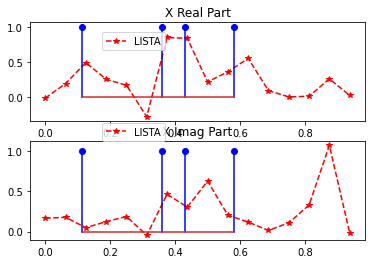

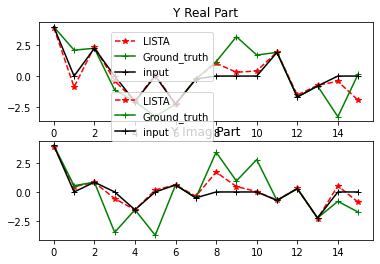

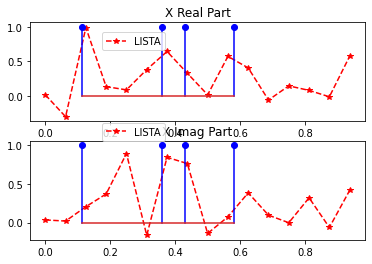

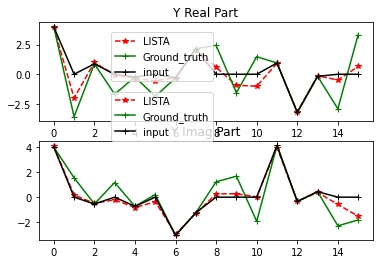

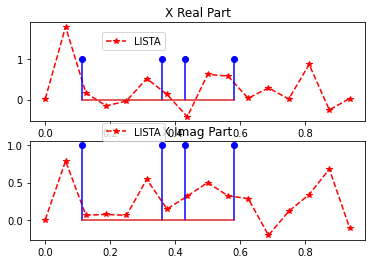

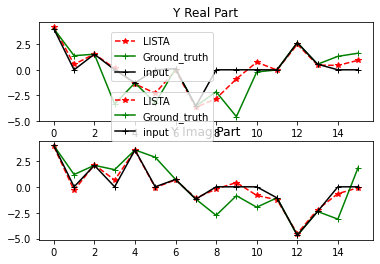

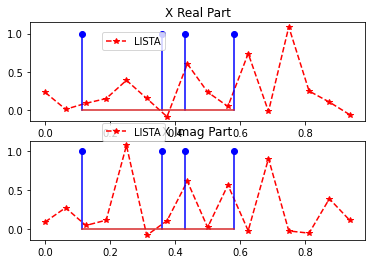

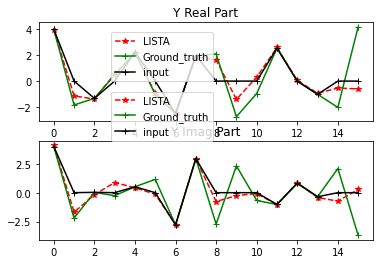

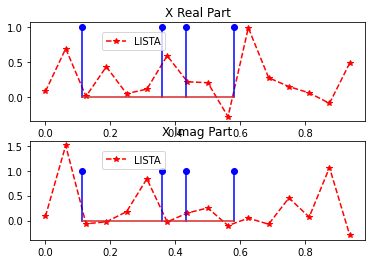

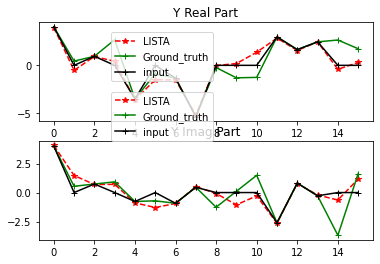

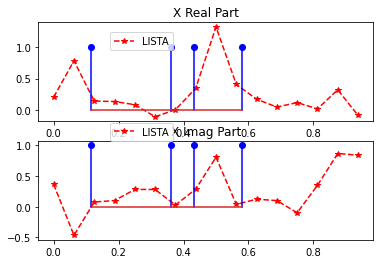

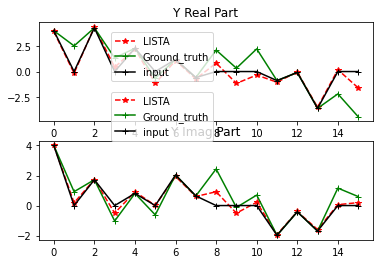

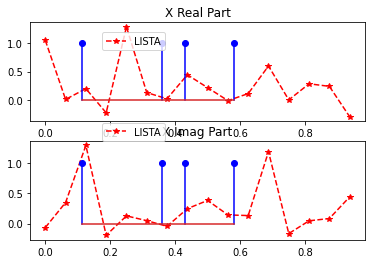

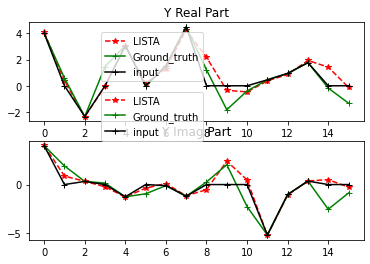

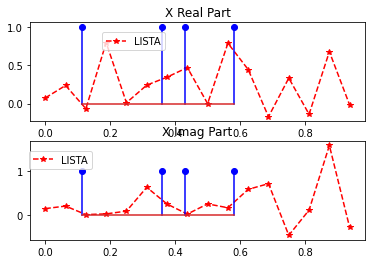

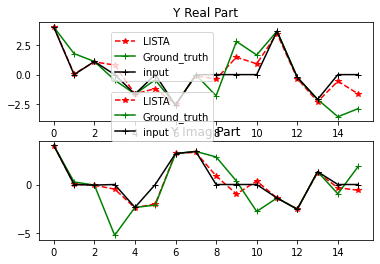

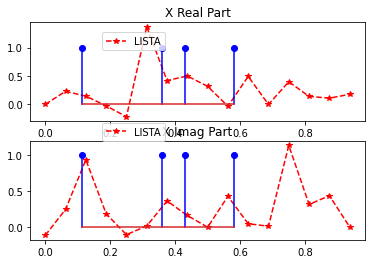

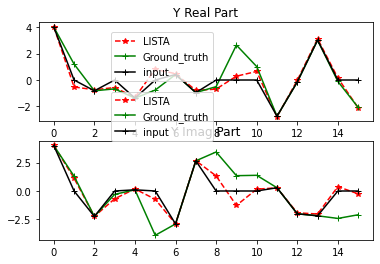

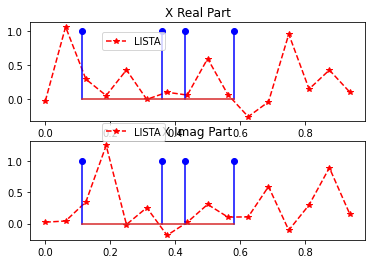

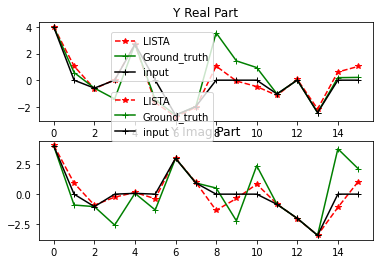

In [ ]:
for i in range(10):
    plt.figure()
    plt.subplot(211)
    plt.plot(f_grid_plt, X_pred_real[:, i], color='red', linestyle='--', marker='*', linewidth=1.5,
             label='LISTA')
    plt.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))

    plt.stem(f_star_plt, wt_gt_real.detach().numpy()[:, i], linefmt='b-', markerfmt='bo')

    plt.title("X Real Part")

    plt.subplot(212)
    plt.plot(f_grid_plt, X_pred_imag[:, i], color='red', linestyle='--', marker='*', linewidth=1.5,
             label='LISTA')
    plt.legend(loc='best', bbox_to_anchor=(0.2, 0.95))
    plt.stem(f_star_plt, wt_gt_imag.detach().numpy()[:, i], linefmt='b-', markerfmt='bo')

    plt.title("X Imag Part")
    # plt.show()
    plt.savefig('X_plot.jpg')

    plt.figure()
    plt.subplot(211)
    plt.plot(Y_pred_real[:, i], color='red', linestyle='--', marker='*', linewidth=1.5,
             label='LISTA')
    plt.plot(yt_gt_real.detach().numpy()[:, i], color='green', linestyle='-', marker='+', linewidth=1.5,
             label='Ground_truth')
    plt.plot(y_valid_input_real.detach().numpy()[:, i], color='black', linestyle='-', marker='+', linewidth=1.5,
             label='input')
    plt.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))
    plt.title("Y Real Part")

    plt.subplot(212)
    plt.plot(Y_pred_imag[:, i], color='red', linestyle='--', marker='*', linewidth=1.5,
             label='LISTA')
    plt.plot(yt_gt_imag.detach().numpy()[:, i], color='green', linestyle='-', marker='+', linewidth=1.5,
             label='Ground_truth')
    plt.plot(y_valid_input_imag.detach().numpy()[:, i], color='black', linestyle='-', marker='+', linewidth=1.5,
             label='input')
    plt.legend(loc='best', bbox_to_anchor=(0.2, 0.95))
    plt.title("Y Imag Part")
    # plt.show()
    plt.savefig('Y_plot.jpg')